In [4]:
%matplotlib inline



Epoching and averaging (ERP/ERF)
================================




In [5]:
import os.path as op
import numpy as np

import mne

In MNE, `epochs` refers to a collection of `single trials` or short segments
of time locked raw data. 
If you haven't already, you might want to check out
`tut_epochs_objects`. 
In this tutorial we take a deeper look into
construction of epochs and averaging the epoch data to evoked instances.
First let's read in the raw sample data.



In [7]:
data_path = mne.datasets.sample.data_path()
fname = op.join(data_path, 'MEG', 'sample', 'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(fname)
raw.set_eeg_reference('average', projection=True)  # set EEG average reference

Opening raw data file /Users/arasdar/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...


FileNotFoundError: [Errno 2] No such file or directory: '/Users/arasdar/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif'

To create time locked epochs, we first need a set of events that contain the
information about the times. 
In this tutorial we use the stimulus channel to
define the events. 
Let's look at the raw data.



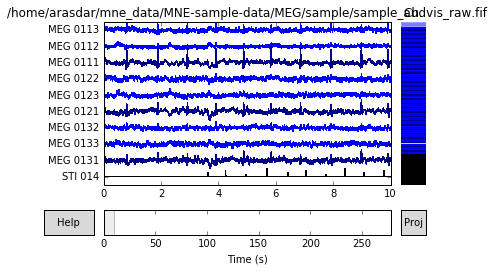

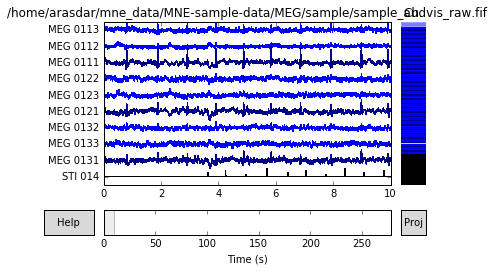

In [7]:
order = np.arange(raw.info['nchan'])
order[9] = 312  # We exchange the plotting order of two channels
order[312] = 9  # to show the trigger channel as the 10th channel.
raw.plot(n_channels=10, order=order, block=True)

Notice channel ``STI 014`` at the bottom. 
It is the trigger channel that
was used for combining all the events to a single channel. 
We can see that it
has several pulses of different amplitude throughout the recording. 
These
pulses correspond to different stimuli presented to the subject during the
acquisition. 
The pulses have values of 1, 2, 3, 4, 5 and 32. 
These are the
events we are going to align the epochs to. 
To create an event list from raw
data, we simply call a function dedicated just for that. 
Since the event list
is simply a numpy array, you can also manually create one. 
If you create one
from an outside source (like a separate file of events), pay special
attention in aligning the events correctly with the raw data.



320 events found
Events id: [ 1  2  3  4  5 32]
Found 320 events, first five:
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


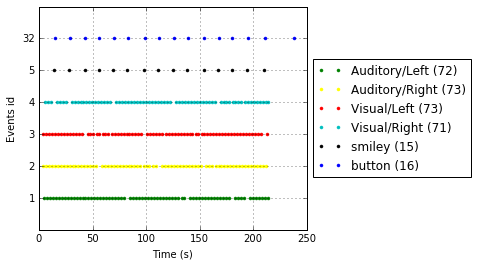

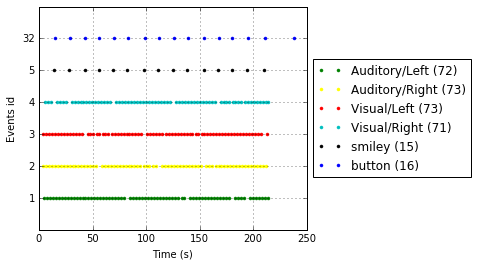

In [11]:
events = mne.find_events(raw)
print('Found %s events, first five:' % len(events))
print(events[:5])

# Plot the events to get an idea of the paradigm
# Specify colors and an event_id dictionary for the legend.
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2,
            'Visual/Left': 3, 'Visual/Right': 4,
            'smiley': 5, 'button': 32}
color = {1: 'green', 2: 'yellow', 3: 'red', 4: 'c', 5: 'black', 32: 'blue'}

mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp, color=color,
                    event_id=event_id)

The event list contains three columns. 
The first column corresponds to
sample number. 
To convert this to seconds, you should divide the sample
number by the used sampling frequency. 
The second column is reserved for the
old value of the trigger channel at the time of transition, but is currently
not in use. 
The third column is the trigger id (amplitude of the pulse).

You might wonder why the samples don't seem to align with the plotted data.
For instance, the first event has a sample number of 27977 which should
translate to roughly 46.6 seconds (27977 / 600). 
However looking at
the pulses we see the first pulse at 3.6 seconds. 
This is because Neuromag
recordings have an attribute ``first_samp`` which refers to the offset
between the system start and the start of the recording. 
Our data has a
``first_samp`` equal to 25800. 
This means that the first sample you see with
``raw.plot`` is the sample number 25800. 
Generally you don't need to worry
about this offset as it is taken into account with MNE functions, but it is
good to be aware of. 
Just to confirm, let's plot the events together with the
raw data. 
Notice how the vertical lines (events) align nicely with the pulses
on `STI 014`.



In [15]:
(27977 - 25800) / 600

3.6283333333333334

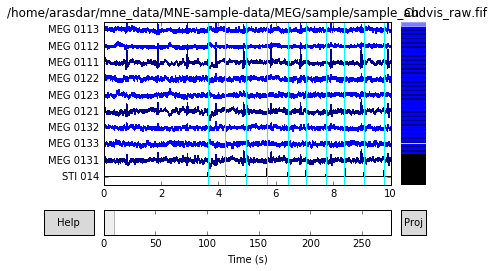

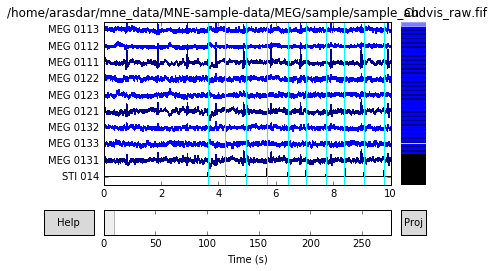

In [16]:
raw.plot(events=events, n_channels=10, order=order)

In this tutorial we are only interested in triggers 1, 2, 3 and 4. 
These
triggers correspond to auditory and visual stimuli. 
The ``event_id`` here
can be an int, a list of ints or a dict. 
With dicts it is possible to assign
these ids to distinct categories. 
When using ints or lists this information
is lost. 
First we shall define some parameters to feed to the
:class:`mne.Epochs` constructor. 
The values ``tmin`` and ``tmax`` refer to
offsets in relation to the events. 
Here we make epochs that collect the data
from 200 ms before to 500 ms after the event.



In [18]:
tmin, tmax = -0.2, 0.5
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2,
            'Visual/Left': 3, 'Visual/Right': 4}
# Only pick MEG and EOG channels.
picks = mne.pick_types(raw.info, meg=True, eeg=False, eog=True)

Now we have everything we need to construct the epochs. 
To get some
meaningful results, we also want to baseline the epochs. 
Baselining computes
the mean over the baseline period and adjusts the data accordingly. 
The
epochs constructor uses a baseline period from ``tmin`` to 0.0 seconds by
default, but it is wise to be explicit. 
That way you are less likely to end
up with surprises along the way. 
``None`` as the first element of the tuple
refers to the start of the time window (-200 ms in this case).
See :class:`mne.Epochs` for more.

We also define rejection thresholds to get rid of noisy epochs. 
The
rejection thresholds are defined as peak-to-peak values within the epoch time
window. 
They are defined as T/m for gradiometers, T for magnetometers and V
for EEG and EOG electrodes.

<div class="alert alert-info"><h4>Note</h4><p>In this tutorial, we don't preprocess the data. 
This is not
          something you would normally do. 
          See our `documentation` on
          preprocessing for more.</p></div>



In [19]:
baseline = (None, 0.0)
reject = {'mag': 4e-12, 'eog': 200e-6}
epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin,
                    tmax=tmax, reject=reject, picks=picks)

289 matching events found
Created an SSP operator (subspace dimension = 3)
3 projection items activated


Let's plot the epochs to see the results. 
The number at the top refers to the
id number. 
We can see that 128 good epochs out of total of 145 events got
through the rejection process. 
Visual inspection also reveals that some
epochs containing saccades or blinks got through. 
You can also reject epochs
by hand by clicking on the epoch in the browser window. The
selected epochs
get rejected when you close the epochs browser. 
How you should reject the
epochs and which thresholds to use is not a trivial question and this
tutorial takes no stand on that matter.

To see all the interactive features of the epochs browser, click 'Help' in
the lower left corner of the browser window.



Loading data for 289 events and 421 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch base

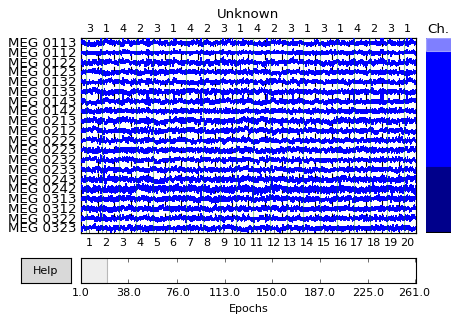

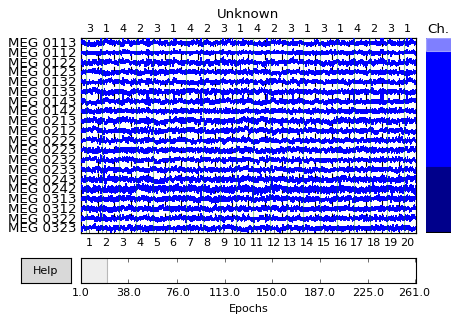

In [20]:
epochs.plot(block=True)

To see why the epochs were rejected, we can plot the drop log.



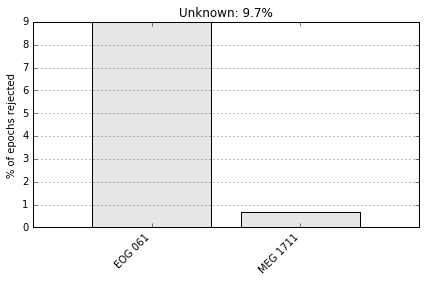

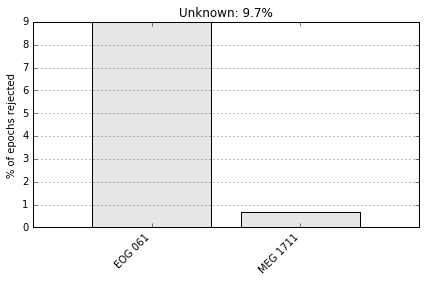

In [21]:
epochs.plot_drop_log()

To get the evoked response you can simply do ``epochs.average()``. It
includes only the data channels by default. For the sake of example, we use
picks to include the EOG channels as well. Notice that we cannot use the
same picks as before as the indices are different. 'Why are they different?'
you might ask. They're different because ``picks`` is simply a list of
channel indices and as the epochs were constructed, also a new info structure
is created where the channel indices run from 0 to ``epochs.info['nchan']``.
See `tut_info_objects` for more information.



In [ ]:
picks = mne.pick_types(epochs.info, meg=True, eog=True)
evoked_left = epochs['Auditory/Left'].average(picks=picks)
evoked_right = epochs['Auditory/Right'].average(picks=picks)

Notice we have used forward slashes ('/') to separate the factors of the
conditions of the experiment. We can use these 'tags' to select for example
all left trials (both visual left and auditory right) ...



In [ ]:
epochs_left = epochs['Left']

# ... or to select a very specific subset. This is the same as above:
evoked_left = epochs['Left/Auditory'].average(picks=picks)

Finally, let's plot the evoked responses.



In [ ]:
evoked_left.plot()
evoked_right.plot()